In [35]:
import pandas as pd 
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from lxml import etree
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.utils.extmath import randomized_svd
import umap


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# importation des données

In [4]:
tree1 = etree.parse("corpus_taln_v2.tei.xml")
#tree2 = etree.parse("exemple-article.xml")

df_cols = ["abstract_fr", "keywords_fr", "intro", "titre", "date"]

In [5]:
def text_cleaner(string):
  if string != None :
    string = string.translate(str.maketrans("\n\t", "  "))
  elif string == None:
    string = "None"
  return (string)

In [6]:
rows=[]
compteur_article = 0

root = tree1.getroot()
for article in root:
  intro = ""
  abstract_fr = ""
  keywords_fr = ""
  titre = ""

  abstract_fr = article[1][0][0][0].text
  keywords_fr = article[1][0][2][0].text

  abstract_fr= text_cleaner(abstract_fr)
  keywords_fr= text_cleaner(keywords_fr)

  try :
    intro = article[1][1][0][1].text
    intro = text_cleaner(intro)
  except :
    oui = 0
  
  titre = article[0][0][0][0].text
  titre = text_cleaner(titre)

  try : 
    date= article[0][0][1][2].text
    date = text_cleaner(date)
  except :
    oui = 0

  rows.append({"abstract_fr": abstract_fr, "keywords_fr":keywords_fr, "intro": intro, "titre": titre, "date":date})
  compteur_article += 1

In [7]:
df = pd.DataFrame(rows, columns = df_cols)
df

,abstract_fr,keywords_fr,intro,titre,date
0,Nous considérons dans notre travail la tâche ...,None,Le modèle de la Grammaire Applicative et Cogn...,Éléments de conception d'un système d'interpr...,1997
1,Nous donnons ici un aperçu du logiciel DECID ...,None,Dans le domaine de l'ingénierie linguistique ...,Informatisation du dictionnaire explicatif et...,1997
2,Diverses méthodes ont été proposées pour cons...,None,,Construction d'une représentation sémantique ...,1997
3,Le terme de lambda-DRT désigne un ensemble de...,None,La « Théorie des Représentations Discursives ...,Systèmes de types pour la (lambda-)DRT ascend...,1998
4,"Dans cet article, nous comparons deux modèles...",None,TAG est un formalisme initialement développé ...,Une grammaire TAG vue comme une grammaire Sen...,1998
...,...,...,...,...,...
1597,"Dans cet article, nous présentons une approch...","Curriculum d'apprentissage, transfert d'appre...",L'apprentissage humain est réalisé par étapes...,Curriculum d'apprentissage : reconnaissance d...,2019
1598,Cet article présente une méthodologie de déte...,"ellipse, anglais, corpus, sous-titres, détect...",L'ellipse renvoie à une incomplétude syntaxiq...,Détection des ellipses dans des corpus de sou...,2019
1599,La génération automatique de poésie est une t...,"génération de poésie, réseaux de neurones, fa...",La génération automatique de poésie est une t...,La génération automatique de poésie en français,2019
1600,Nous proposons une architecture neuronale ave...,"Réseaux neuronaux, modélisation de séquences,...",L'étiquetage de séquences est un problème imp...,Modèles neuronaux hybrides pour la modélisati...,2019


In [8]:
compteur_article

1602

# création de keywords en se basant sur les abstracts

In [9]:
tokenizer=RegexpTokenizer("[\w]+")



replacement_patterns = [
(r'd\'', 'de '),
(r'l\'', 'le '),
(r',', ' '),
(r'-', ' ')
]

class RegexpReplacer(object):
   def __init__(self, patterns=replacement_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
           s = re.sub(pattern, repl, s)
      return s

replacer = RegexpReplacer()

In [10]:
tokenized_abstract = []
cleaned_abstract = []
for abstract in df['abstract_fr'] :
  tokenized_abstract.append((tokenizer.tokenize(replacer.replace(abstract.lower()))))
  cleaned_abstract.append(replacer.replace(abstract.lower()))

df['tokenized_abstract'] = tokenized_abstract
df['cleaned_abstract'] = cleaned_abstract

In [11]:
df.head()

,abstract_fr,keywords_fr,intro,titre,date,tokenized_abstract,cleaned_abstract
0,Nous considérons dans notre travail la tâche ...,None,Le modèle de la Grammaire Applicative et Cogn...,Éléments de conception d'un système d'interpr...,1997,"[nous, considérons, dans, notre, travail, la, ...",nous considérons dans notre travail la tâche ...
1,Nous donnons ici un aperçu du logiciel DECID ...,None,Dans le domaine de l'ingénierie linguistique ...,Informatisation du dictionnaire explicatif et...,1997,"[nous, donnons, ici, un, aperçu, du, logiciel,...",nous donnons ici un aperçu du logiciel decid ...
2,Diverses méthodes ont été proposées pour cons...,None,,Construction d'une représentation sémantique ...,1997,"[diverses, méthodes, ont, été, proposées, pour...",diverses méthodes ont été proposées pour cons...
3,Le terme de lambda-DRT désigne un ensemble de...,None,La « Théorie des Représentations Discursives ...,Systèmes de types pour la (lambda-)DRT ascend...,1998,"[le, terme, de, lambda, drt, désigne, un, ense...",le terme de lambda drt désigne un ensemble de...
4,"Dans cet article, nous comparons deux modèles...",None,TAG est un formalisme initialement développé ...,Une grammaire TAG vue comme une grammaire Sen...,1998,"[dans, cet, article, nous, comparons, deux, mo...",dans cet article nous comparons deux modèles...


In [12]:
common_word = pd.Series(' '.join(df['cleaned_abstract']).split()).value_counts()[:25]
common_word

de         16765
le          6506
des         5036
la          4953
les         3866
et          3802
un          3253
à           3127
une         3117
nous        3021
en          2570
dans        2363
pour        2303
sur         1878
du          1598
est         1321
par         1191
que         1156
qui         1021
corpus      1005
cet          967
article      945
sont         821
cette        739
ces          714
dtype: int64

In [13]:
nltk.download('wordnet')
lemmatizer_output=WordNetLemmatizer()
for index in range(len(df['tokenized_abstract'])) :
  df['tokenized_abstract'][index] = [lemmatizer_output.lemmatize(word.lower(), pos='v') for word in df['tokenized_abstract'][index] if word not in common_word] 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [14]:
df.head()

,abstract_fr,keywords_fr,intro,titre,date,tokenized_abstract,cleaned_abstract
0,Nous considérons dans notre travail la tâche ...,None,Le modèle de la Grammaire Applicative et Cogn...,Éléments de conception d'un système d'interpr...,1997,"[considérons, notre, travail, tâche, traitemen...",nous considérons dans notre travail la tâche ...
1,Nous donnons ici un aperçu du logiciel DECID ...,None,Dans le domaine de l'ingénierie linguistique ...,Informatisation du dictionnaire explicatif et...,1997,"[donnons, ici, aperçu, logiciel, decid, dévelo...",nous donnons ici un aperçu du logiciel decid ...
2,Diverses méthodes ont été proposées pour cons...,None,,Construction d'une représentation sémantique ...,1997,"[diverses, méthodes, ont, été, proposées, cons...",diverses méthodes ont été proposées pour cons...
3,Le terme de lambda-DRT désigne un ensemble de...,None,La « Théorie des Représentations Discursives ...,Systèmes de types pour la (lambda-)DRT ascend...,1998,"[terme, lambda, drt, désigne, ensemble, méthod...",le terme de lambda drt désigne un ensemble de...
4,"Dans cet article, nous comparons deux modèles...",None,TAG est un formalisme initialement développé ...,Une grammaire TAG vue comme une grammaire Sen...,1998,"[comparons, deux, modèles, linguistiques, util...",dans cet article nous comparons deux modèles...


In [15]:
# Ici nous supprimons les lignes n'ayant ni abstract ni keyword

num_line = []
for index in range(0, len(df)):
  if (df['abstract_fr'][index] == 'None' or df['abstract_fr'][index] == ' ') and df['keywords_fr'][index] == 'None':
    num_line.append(index)

print(num_line)
num_line.append(1545)
df = df.drop(num_line)
df.reset_index(inplace = True)
len(df)

[17, 20, 25, 26, 27, 30, 43, 47, 49, 51, 53, 56, 58, 66, 67, 68, 70, 71, 81, 82, 83, 84, 122, 137, 193, 254, 333, 637, 686, 737, 802, 818, 833, 834, 845, 931, 932, 933, 936, 937, 938, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 952, 953, 1205, 1291, 1292]


1544

In [16]:
from collections import Counter

list_useless = ['algorithme', 'qui', 'que', 'selon', 'mais', 'texte', 'aperçu', 'textes', 'afin', 'donc', 'travail', 'tâche', 'cependant', 'alors', 'droite', 'gauche', 'sous', 'forme', 'partie', 'entre', 'partir', 'a', 'ici', 'plus', 'moins', 'exemple', 'analyse']
for i in range (0,150) :
  list_useless.append(str(i))

new_keywords = []
for index in range(0, len(df)):
  keywords_list = []
  cnt = Counter()
  for mot in df['tokenized_abstract'][index]:
    if len(mot) > 2:
      if mot not in list_useless :
        if mot[len(mot)-3] != 'o' and mot[len(mot)-2] != "n" and mot[len(mot)-1] != "s" :
          if mot[len(mot)-3] != 'a' and mot[len(mot)-2] != "i" and mot[len(mot)-1] != "t" :
            cnt[mot] += 1
  #print(cnt)
  #print(index)
  if df['abstract_fr'][index] != 'None' :
    word, max_count = cnt.most_common()[0]
    for mot in df['tokenized_abstract'][index]:
      if cnt[mot] == max_count and mot not in keywords_list:
        keywords_list.append(mot)
    if df['keywords_fr'][index] == None :
      df['keywords_fr'][index] = keywords_list
  new_keywords.append(keywords_list)

In [17]:
for index in range(0, len(df)):
  keywords_list = []
  if df['keywords_fr'][index] != 'None' :
    keywords_list = str(df['keywords_fr'][index]).split(',')
  new_keywords[index] = new_keywords[index] + keywords_list


df['new_keywords'] = new_keywords
df

,index,abstract_fr,keywords_fr,intro,titre,date,tokenized_abstract,cleaned_abstract,new_keywords
0,0,Nous considérons dans notre travail la tâche ...,None,Le modèle de la Grammaire Applicative et Cogn...,Éléments de conception d'un système d'interpr...,1997,"[considérons, notre, travail, tâche, traitemen...",nous considérons dans notre travail la tâche ...,"[notre, automatique, relative, système, grande..."
1,1,Nous donnons ici un aperçu du logiciel DECID ...,None,Dans le domaine de l'ingénierie linguistique ...,Informatisation du dictionnaire explicatif et...,1997,"[donnons, ici, aperçu, logiciel, decid, dévelo...",nous donnons ici un aperçu du logiciel decid ...,"[logiciel, développé, geta, informatiser, réda..."
2,2,Diverses méthodes ont été proposées pour cons...,None,,Construction d'une représentation sémantique ...,1997,"[diverses, méthodes, ont, été, proposées, cons...",diverses méthodes ont été proposées pour cons...,"[syntaxique, construction, représentation, sém..."
3,3,Le terme de lambda-DRT désigne un ensemble de...,None,La « Théorie des Représentations Discursives ...,Systèmes de types pour la (lambda-)DRT ascend...,1998,"[terme, lambda, drt, désigne, ensemble, méthod...",le terme de lambda drt désigne un ensemble de...,"[terme, lambda, ensemble, construire, mise, oe..."
4,4,"Dans cet article, nous comparons deux modèles...",None,TAG est un formalisme initialement développé ...,Une grammaire TAG vue comme une grammaire Sen...,1998,"[comparons, deux, modèles, linguistiques, util...",dans cet article nous comparons deux modèles...,[tag]
...,...,...,...,...,...,...,...,...,...
1539,1597,"Dans cet article, nous présentons une approch...","Curriculum d'apprentissage, transfert d'appre...",L'apprentissage humain est réalisé par étapes...,Curriculum d'apprentissage : reconnaissance d...,2019,"[présentons, approche, bout, bout, extraction,...",dans cet article nous présentons une approch...,"[système, Curriculum d'apprentissage, transf..."
1540,1598,Cet article présente une méthodologie de déte...,"ellipse, anglais, corpus, sous-titres, détect...",L'ellipse renvoie à une incomplétude syntaxiq...,Détection des ellipses dans des corpus de sou...,2019,"[présente, méthodologie, détection, ellipses, ...",cet article présente une méthodologie de déte...,"[leur, ellipse, anglais, corpus, sous-titr..."
1541,1599,La génération automatique de poésie est une t...,"génération de poésie, réseaux de neurones, fa...",La génération automatique de poésie est une t...,La génération automatique de poésie en français,2019,"[génération, automatique, poésie, tâche, ardue...",la génération automatique de poésie est une t...,"[génération, génération de poésie, réseaux d..."
1542,1600,Nous proposons une architecture neuronale ave...,"Réseaux neuronaux, modélisation de séquences,...",L'étiquetage de séquences est un problème imp...,Modèles neuronaux hybrides pour la modélisati...,2019,"[proposons, architecture, neuronale, avec, car...",nous proposons une architecture neuronale ave...,"[architecture, avec, Réseaux neuronaux, modé..."


# clustering sur les keywords de base

In [18]:
stop_words = stopwords.words('french')

#liste de tous les keywords du dataframe
list_keywords = []
for i in range(len(df)):
  if df.keywords_fr[i] != "None":
    list_keywords.append(df.keywords_fr[i])

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf vectorizer de la librairies sklearn
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(list_keywords)
print(X.shape)

terms = vectorizer.get_feature_names()

(1474, 1000)


In [20]:
#clustering
num_clusters = 9
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_.tolist()

In [21]:
#affichage des thèmes principaux

U, Sigma, VT = randomized_svd(X, n_components=9, n_iter=1000, random_state=122)

for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("themes "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

themes 0: 
analyse
automatique
syntaxique
analyse syntaxique
sémantique
corpus
traduction
 
themes 1: 
analyse
syntaxique
analyse syntaxique
grammaire
grammaires
dépendance
morpho syntaxique
 
themes 2: 
extraction
information
extraction information
entités
entités nommées
nommées
recherche
 
themes 3: 
sémantique
lexicale
sémantique lexicale
similarité
désambiguïsation
similarité sémantique
distributionnelle
 
themes 4: 
entités
entités nommées
nommées
reconnaissance
sémantique
reconnaissance entités nommées
reconnaissance entités
 
themes 5: 
corpus
annotation
dialogue
linguistique
apprentissage
homme
machine
 
themes 6: 
dialogue
homme
machine
homme machine
dialogue homme
dialogue homme machine
évaluation
 
themes 7: 
grammaire
grammaires
syntaxe
arbres
adjoints
syntaxe sémantique
arbres adjoints
 
themes 8: 
apprentissage
classification
apprentissage automatique
automatique
grammaires
supervisé
grammaire
 


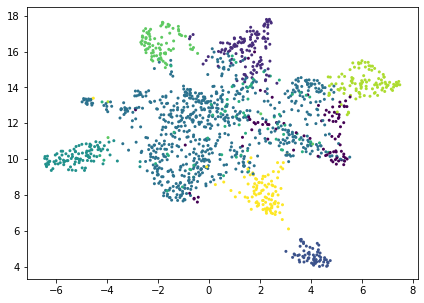

In [22]:
X_topics=U*Sigma
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters, s = 9, edgecolor='none')
plt.show()


# Clustering avec tous les keywords crées

In [23]:
df2 = df.copy()

for i  in range(len(df2)):
  if df2.keywords_fr[i] == "None" :
    keyword = ""
    for j in range (len(df2.new_keywords[i])):
      keyword = keyword + df2.new_keywords[i][j] + ", "
    df2.keywords_fr[i] = keyword
  else :
    keyword = ""
    for j in range (len(df2.new_keywords[i])):
      if df2.new_keywords[i][j] not in df2.keywords_fr[i] :
        keyword = keyword + df2.new_keywords[i][j] + ", "
    df2.keywords_fr[i] = df2.keywords_fr[i] + keyword

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
list_keywords2 = []
for i in range(len(df2)):
  if df2.keywords_fr[i] != "None":
    list_keywords2.append(df2.keywords_fr[i])
 

In [25]:
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X2 = vectorizer.fit_transform(list_keywords2)
print(X2.shape)

terms2 = vectorizer.get_feature_names()

(1544, 10000)


In [26]:
num_clusters = 9
km2 = KMeans(n_clusters=num_clusters)
km2.fit(X2)
clusters2 = km2.labels_.tolist()

In [27]:
U, Sigma, VT = randomized_svd(X2, n_components=9, n_iter=100, random_state=122)

for i, comp in enumerate(VT):
        terms_comp = zip(terms2, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("themes "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

themes 0: 
analyse
automatique
sémantique
syntaxique
traduction
analyse syntaxique
corpus
 
themes 1: 
traduction
automatique
traduction automatique
statistique
automatique statistique
traduction automatique statistique
résumé
 
themes 2: 
sémantique
lexicale
sémantique lexicale
similarité
similarité sémantique
distributionnelle
désambiguïsation
 
themes 3: 
extraction
information
extraction information
entités
entités nommées
nommées
recherche
 
themes 4: 
dialogue
homme
homme machine
machine
système
dialogue homme
dialogue homme machine
 
themes 5: 
grammaire
grammaires
extraction
information
arbres
adjoints
arbres adjoints
 
themes 6: 
question
réponse
système
question réponse
résumé
analyse
système question
 
themes 7: 
système
question
réponse
question réponse
entités nommées
nommées
entités
 
themes 8: 
résumé
résumé automatique
automatique
reconnaissance
textes
entités nommées
nommées
 


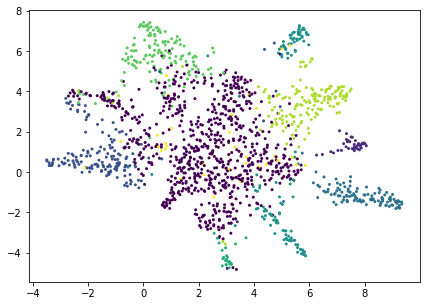

In [28]:
X_topics=U*Sigma
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters2, s = 9, edgecolor='none')
plt.show()

# Résumé par mot clef

In [29]:
keyword = "traduction"

text = []
for index in range(0, len(df)):
  if keyword in df['new_keywords'][index]:
    text.append(df['abstract_fr'][index].split("."))
  
print(len(text))


78


In [30]:
replacement_patterns_bis = [
(r'd\'', 'de '),
(r'l\'', 'le '),
(r'é', 'e'),
(r'à', 'a'),
(r'è', 'e'),
(r'ù', 'u'),
(r'ê', 'e')
]

replacer = RegexpReplacer(replacement_patterns_bis)

sentences = []
for sentence in text:
  sentence = replacer.replace(str(sentence))
  sentence = re.sub("[^a-zA-Z]", ' ', sentence)
  sentence = re.sub("[\s+]", ' ', sentence)
  sentences.append(sentence)

print(len(sentences))

78


In [31]:
bagofword = []
for sentence in sentences:
  bagofword = set(bagofword).union(set(sentence.split(" ")))

print(bagofword)

{'', 'corpus', 'lineaire', 'Portal', 'modulaire', 'plates', 'croissante', 'focalise', 'generalement', 'possibilites', 'resoudre', 'qu', 'ligne', 'fragments', 'unique', 'tirons', 'bi', 'baselines', 'inconnues', 'vers', 'engendres', 'arbitraire', 'potentiellement', 'Des', 'existantes', 'traditionnelles', 'professionnels', 'Meme', 'd', 'quel', 'serait', 'exploitees', 'archetypal', 'discriminante', 'existants', 'identification', 'divergences', 'jouent', 'superieurs', 'Cetteapplication', 'Langues', 'informels', 'free', 'appelons', 'entra', 'actuelles', 'teuse', 'avec', 'neuronaux', 'European', 'limitations', 'apporter', 'effectuee', 'predictions', 'pu', 'traduction', 'recouvrements', 'fine', 'moment', 'informations', 'apprehender', 'via', 'Chuquet', 'titres', 'materiel', 'motivees', 'le', 'occasion', 'analysons', 'ecrire', 'M', 'meilleure', 'mantics', 'mesures', 'Traitement', 'differents', 'peu', 'manque', 'tunisien', 'realiser', 'traitements', 'representation', 'suivants', 'codage', 'conte

In [32]:
list_numOfWords =[]
for sentence in sentences :
  numOfWords = dict.fromkeys(bagofword, 0)
  by_word = sentence.split(" ")
  for mot in by_word:
    numOfWords[mot] = numOfWords[mot] + 1
  list_numOfWords.append(numOfWords)

print(len(list_numOfWords))
print(type(list_numOfWords))
print(type(list_numOfWords[0]))

78
<class 'list'>
<class 'dict'>


In [33]:
def TF(wordDict, bagOfWords):
    tf = {}
    count = len(bagOfWords)
    for word, cnt in wordDict.items():
        tf[word] = cnt / float(count)
    return tf

print(TF(list_numOfWords[0], sentences[0]))

{'': 0.03209876543209877, 'corpus': 0.0, 'lineaire': 0.0, 'Portal': 0.0, 'modulaire': 0.0, 'plates': 0.0, 'croissante': 0.0, 'focalise': 0.0, 'generalement': 0.0012345679012345679, 'possibilites': 0.0012345679012345679, 'resoudre': 0.0, 'qu': 0.0012345679012345679, 'ligne': 0.0, 'fragments': 0.0, 'unique': 0.0, 'tirons': 0.0, 'bi': 0.0, 'baselines': 0.0, 'inconnues': 0.0, 'vers': 0.0, 'engendres': 0.0, 'arbitraire': 0.0, 'potentiellement': 0.0, 'Des': 0.0, 'existantes': 0.0, 'traditionnelles': 0.0012345679012345679, 'professionnels': 0.0, 'Meme': 0.0, 'd': 0.0, 'quel': 0.0, 'serait': 0.0, 'exploitees': 0.0, 'archetypal': 0.0, 'discriminante': 0.0, 'existants': 0.0, 'identification': 0.0, 'divergences': 0.0, 'jouent': 0.0, 'superieurs': 0.0, 'Cetteapplication': 0.0, 'Langues': 0.0, 'informels': 0.0, 'free': 0.0, 'appelons': 0.0, 'entra': 0.0, 'actuelles': 0.0, 'teuse': 0.0, 'avec': 0.0, 'neuronaux': 0.0, 'European': 0.0, 'limitations': 0.0, 'apporter': 0.0, 'effectuee': 0.0, 'prediction

In [36]:
def IDF(sentences):
    N = len(sentences)
    idf = dict.fromkeys(bagofword, 1)
    for word in bagofword:
      for index in range(0,N):
        for word_text in by_word:
            if word_text == word:
                idf[word] = idf[word] + 1
    for word, val in idf.items():
        idf[word] = math.log(N / float(val))
    return idf

idf = IDF(sentences)

In [37]:
def TFIDF(TF, IDF):
    tfidf = {}
    for word, val in TF.items():
        tfidf[word] = val * IDF[word]
    return tfidf

print(TFIDF(TF(list_numOfWords[0], sentences[0]), idf))

{'': -0.10918795143312877, 'corpus': -0.0, 'lineaire': 0.0, 'Portal': 0.0, 'modulaire': 0.0, 'plates': 0.0, 'croissante': 0.0, 'focalise': 0.0, 'generalement': 0.005378652872456286, 'possibilites': 0.005378652872456286, 'resoudre': 0.0, 'qu': 0.005378652872456286, 'ligne': 0.0, 'fragments': 0.0, 'unique': 0.0, 'tirons': 0.0, 'bi': 0.0, 'baselines': 0.0, 'inconnues': 0.0, 'vers': 0.0, 'engendres': 0.0, 'arbitraire': 0.0, 'potentiellement': 0.0, 'Des': 0.0, 'existantes': 0.0, 'traditionnelles': 0.005378652872456286, 'professionnels': 0.0, 'Meme': 0.0, 'd': 0.0, 'quel': 0.0, 'serait': 0.0, 'exploitees': 0.0, 'archetypal': 0.0, 'discriminante': 0.0, 'existants': 0.0, 'identification': 0.0, 'divergences': 0.0, 'jouent': 0.0, 'superieurs': 0.0, 'Cetteapplication': 0.0, 'Langues': 0.0, 'informels': 0.0, 'free': 0.0, 'appelons': 0.0, 'entra': 0.0, 'actuelles': 0.0, 'teuse': 0.0, 'avec': 0.0, 'neuronaux': -0.0, 'European': 0.0, 'limitations': 0.0, 'apporter': 0.0, 'effectuee': 0.0, 'predictions

In [38]:
def score_sentences(doc):
    total_score = []
    for index in range(0,len(doc)):
        tfidf = TFIDF(TF(list_numOfWords[index], sentences[index]), idf)
        score = 0
        by_word = sentences[index].split(" ")
        for mot in by_word:
            score = score + tfidf[mot]
        dic = {'sentence': sentence, 'score': score}
        total_score.append(dic)
    return total_score

In [39]:
def resume(sentence_score):
    count = 0
    resume = []
    for dico in sentence_score:
        count += dico['score']
    moyenne = count / len(sentence_score)
    for dico in sentence_score:
        if dico['score']>= 0.9*moyenne:
            resume.append(dico['sentence']) 
    resume = ". ".join(resume)
    return resume

In [40]:
score = score_sentences(text)
resume(score)

'   L apprentissage par transfert est une solution au probleme de le apprentissage de systemes de traduction automatique neuronaux pour des paires de langues peu dotees     Dans cet article  nous proposons une analyse de cette methode     Nous souhaitons evaluer le impact de la quantite de donnees et celui de la proximite des langues impliquees pour obtenir le meilleur transfert possible     Nous prenons en compte ces deux parametres non seulement pour une t che de traduction  quot classique quot  mais egalement lorsque les corpus de donnees font defaut     Enfin  il s agit de proposer une approche ou volume de donnees et proximite des langues sont combinees afin de ne plus avoir a trancher entre ces deux elements       .    L apprentissage par transfert est une solution au probleme de le apprentissage de systemes de traduction automatique neuronaux pour des paires de langues peu dotees     Dans cet article  nous proposons une analyse de cette methode     Nous souhaitons evaluer le imp